<a href="https://colab.research.google.com/github/jmarrietar/ocular/blob/master/notebooks/Metrics_(voets_partition).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF 2.0 - Test Metrics 

In [10]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-8b09c405-2fef-6a65-7849-1fff7cadcaf3)


In [11]:
# Mount Drive
from google.colab import drive
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

In [12]:
auth.authenticate_user()
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os
import zipfile
import itertools
import numpy as np
import h5py
import random
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix 
%matplotlib inline

import tensorflow as tf

import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model, model_from_json
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

print(f"Numpy version: {np.__version__}")
print(f"Tensorflow version: {tf.__version__}")

random.seed(432)

Numpy version: 1.19.5
Tensorflow version: 2.6.0


In [14]:
# Parameters 
BATCH_SIZE = 32
num_workers = 8
num_epochs = 200
learning_rate = 1e-6
decay = 4e-5
min_delta_auc = 0.01
BATCH_SIZE = 32
img_width, img_height = 299, 299

#### Download data

In [15]:
!gdown https://drive.google.com/uc?id=1Y0pDtx-5HdDcXFWyp2Kcjc4DCG65VLAH

Downloading...
From: https://drive.google.com/uc?id=1Y0pDtx-5HdDcXFWyp2Kcjc4DCG65VLAH
To: /content/eyepacs.zip
100% 4.79G/4.79G [00:53<00:00, 89.2MB/s]
Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/gdown/cli.py", line 61, in main
    quiet=args.quiet,
  File "/usr/local/lib/python2.7/dist-packages/gdown/download.py", line 109, in download
    shutil.copy(tmp_file, output)
  File "/usr/lib/python2.7/shutil.py", line 139, in copy
    copyfile(src, dst)
  File "/usr/lib/python2.7/shutil.py", line 98, in copyfile
    copyfileobj(fsrc, fdst)
  File "/usr/lib/python2.7/shutil.py", line 63, in copyfileobj
    buf = fsrc.read(length)
KeyboardInterrupt


In [ ]:
!gdown https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p

In [ ]:
import zipfile
local_zip = '/content/eyepacs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
local_zip = '/content/messidor2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
# Train data 
train_dir_1 = os.path.join('/content/eyepacs/train/1')
train_dir_0 = os.path.join('/content/eyepacs/train/0')

print("Total imagenes training Diabetic Retinopathy:", len(os.listdir(train_dir_1)))
print(
    "Total imagenes training Non Diabetic Retinopathy:",
    len(os.listdir(train_dir_0)),
)

In [ ]:
# Test data
test_dir_1 = os.path.join('/content/eyepacs/test/1')
test_dir_0 = os.path.join('/content/eyepacs/test/0')

print("Total imagenes Test Diabetic Retinopathy:", len(os.listdir(test_dir_1)))
print(
    "Total imagenes Test Non Diabetic Retinopathy:",
    len(os.listdir(test_dir_0)),
)

In [ ]:
dr_files = os.listdir(train_dir_1)
no_dr_files = os.listdir(train_dir_0)

In [ ]:
pic_index = 2

next_dr = [os.path.join(train_dir_1, fname) for fname in dr_files[pic_index - 2 : pic_index]]
next_no_dr = [
    os.path.join(train_dir_0, fname) for fname in no_dr_files[pic_index - 2 : pic_index]
]

for i, img_path in enumerate(next_dr + next_no_dr):

    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis("Off")
    plt.show()

In [ ]:
def preprocessing(image):
    image = tf.image.random_brightness(image, 0.125)
    image = tf.image.random_saturation(image, 0.5, 1.5)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_contrast(image, 0.5, 1.5)
    return image

In [ ]:
TRAINING_DIR = "/content/eyepacs/train/"
TEST_DIR = "/content/eyepacs/test"
TEST_MESSIDOR_DIR = "/content/messidor2"

datagen = ImageDataGenerator(
    samplewise_center=True,
    horizontal_flip=True,
    rescale=1./255,
    preprocessing_function=preprocessing,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset='training',
    shuffle=True,
)


In [ ]:
train_generator2 = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_width, img_height),
    color_mode='rgb',
    batch_size=1,
    class_mode="binary",
    shuffle=False,
)

In [ ]:
test_datagen = ImageDataGenerator(samplewise_center = True, 
                                  rescale=1./255)

test_generator = test_datagen.flow_from_directory(
	TEST_DIR,
    target_size=(img_width, img_height),
    color_mode='rgb',
	class_mode='binary', 
    batch_size=1,
    shuffle=False,
)

In [ ]:
batch_size = 32

messidor_datagen = ImageDataGenerator(samplewise_center = True, 
                                      rescale=1./255)

messidor_generator = messidor_datagen.flow_from_directory(
	TEST_MESSIDOR_DIR,
    target_size=(img_width, img_height),
    color_mode='rgb',
	class_mode='binary', 
    batch_size=1,
    shuffle=False,
)

In [ ]:
model_information = {
    "sample@500": {
        "data": "https://drive.google.com/uc?id=1dHwUqpmSogEdjAB9rwDUL-OKFRUcVXte",
        "JSON_STRUCTURE_FILE": "InceptionV3_warm_up_sample@500.json",
        "WEIGHTS_FILE": "InceptionV3-sample@500-epochs:063-val_loss:0.570.hdf5",
    },
    "sample@1000": {
        "data": "https://drive.google.com/uc?id=1DPZrHrj3Bdte5Dc6NCZ33CAqMG-Oipa2",
        "JSON_STRUCTURE_FILE": "InceptionV3_warm_up_sample@1000.json",
        "WEIGHTS_FILE": "InceptionV3-sample@1000-epochs:043-val_loss:0.585.hdf5",
    },
    "sample@2000": {
        "data": "https://drive.google.com/uc?id=1PB7uGd-dUnZKnKZpZl-HvE1DVcWgX50F",
        "JSON_STRUCTURE_FILE": "InceptionV3_warm_up_sample@2000.json",
        "WEIGHTS_FILE": "InceptionV3-sample@2000-epochs:001-val_loss:0.562.hdf5",
    },
    "sample@3000": {
        "data": "https://drive.google.com/uc?id=1_yre5K9YYvJgSrT4xvrI8eD_htucIywA",
        "JSON_STRUCTURE_FILE": "InceptionV3_warm_up_sample@3000.json",
        "WEIGHTS_FILE": "InceptionV3-sample@3000-epochs:002-val_loss:0.563.hdf5",
    },
}

In [ ]:
SAMPLE = "sample@2000"

In [ ]:
JSON_STRUCTURE_FILE = model_information[SAMPLE]["JSON_STRUCTURE_FILE"]
WEIGHTS_FILE = model_information[SAMPLE]["WEIGHTS_FILE"]

In [ ]:
#with strategy.scope():
# Load json file structure and create model
json_file = open('drive/My Drive/Project/model/{}'.format(JSON_STRUCTURE_FILE), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

In [ ]:
#with strategy.scope():
#Load weights into new model
model.load_weights('drive/My Drive/Project/model/{}'.format(WEIGHTS_FILE))
print("Loaded model from Drive")

In [ ]:
for layer in model.layers:
    layer.trainable = False

# change the learning rate
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate,
                                       decay=decay),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

## 2 Metrics

Auxiliar Functions

In [ ]:
def create_plots(y_true, y_pred, y_pred_prob):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob, pos_label=1)
    cm=metrics.confusion_matrix(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_prob)
    print('AUC: %.3f' % auc)
    print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))

    # Plot ROC curve
    lw = 2
    sns.set_style({'axes.grid' : False})
    sns.set_style("darkgrid")
    ax1 = sns.lineplot(fpr, tpr, color='darkorange',
            lw=lw, label='AUC = %0.2f' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax1.set_title('Receiver operating characteristic')
    ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Confusion Matrix 
    fig, ax2 = plot_confusion_matrix(conf_mat=cm,
                                    show_normed=False)
    plt.show()

#### Metrics on Kaggle train (voets)

In [ ]:
"""
train_generator2.reset()
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(train_generator2, 2)
y_true = train_generator2.classes
y_pred_prob = model.predict(train_generator2,verbose=1,workers=0)
y_pred_prob = np.hstack(y_pred_prob)
y_pred = (y_pred_prob> threshold).astype('int')
"""

In [ ]:
#create_plots(y_true, y_pred, y_pred_prob)

#### Metrics on Kaggle test (voets)

In [ ]:
threshold = 0.5
y_true = test_generator.classes
y_pred_prob = model.predict_generator(test_generator, verbose=1, workers=5)
y_pred_prob = np.hstack(y_pred_prob)
y_pred = (y_pred_prob> threshold).astype('int')

In [ ]:
create_plots(y_true, y_pred, y_pred_prob)

#### Metrics on Messidor-2

In [ ]:
threshold = 0.5
y_true = messidor_generator.classes
y_pred_prob = model.predict(messidor_generator, verbose=1, workers=5)
y_pred_prob = np.hstack(y_pred_prob)
threshold = 0.5
y_pred = (y_pred_prob> threshold).astype('int')

In [ ]:
threshold = 0.5
y_pred = (y_pred_prob> threshold).astype('int')

In [ ]:
create_plots(y_true, y_pred, y_pred_prob)

-----------------------

---------- 

# Test MixMatch

Pytorch Approach

In [7]:
import torch
import numpy as np
import zipfile
from skimage import io, transform
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import models
from torchvision import transforms

In [16]:
# Mount Drive
from google.colab import drive
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

In [20]:
drive.mount('/content/drive')
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
test_data = {
    "voets_test_images": "https://drive.google.com/uc?id=15S_V3B_Z3BOjCT3AbO2c887FyS5B0Lyd",
    "messidor2": "https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p",
}

TEST_DATASET = 'messidor2'
URL_TEST_DATASET = test_data[TEST_DATASET]

In [22]:
!gdown $URL_TEST_DATASET

Downloading...
From: https://drive.google.com/uc?id=15S_V3B_Z3BOjCT3AbO2c887FyS5B0Lyd
To: /content/voets_test_images.zip
100% 475M/475M [00:13<00:00, 34.6MB/s]


In [ ]:
local_zip = '{}.zip'.format(TEST_DATASET)
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
def create_model(device, ema=False):
    model = models.densenet169(pretrained=True)
    ft = model.classifier.in_features
    model.classifier = torch.nn.Linear(ft, 2)
    model = model.to(device)

    if ema:
        for param in model.parameters():
            param.detach_()

    return model

In [ ]:
class Test_Dataset(Dataset):
    def __init__(self, fname):
        self.data = {}
        with open(fname, 'r') as f:
            for l in f.readlines():
                l = l.split(',')
                self.data[l[0]] = int(l[1])
        self.keys = list(self.data.keys())

        with tqdm(total=len(self.keys)) as pbar:
            for key in self.keys:
                self.data[key] = (self.data[key], self.load(key))
                pbar.set_description("Loading images")
                pbar.update(1)

        self.norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.keys)

    def load(self, fname):
        img = io.imread(fname)
        return img

    def preprocess(self, img):
        img = img / 255.0

        img = transform.resize(img, [224, 224, 3], mode='constant', anti_aliasing=True)
        img = self.tensor(img)
        img = self.norm(img.float())

        img = img.type(torch.float32)
        return img

    def __getitem__(self, idx):
        key = self.keys[idx]
        label = self.data[key][0]
        img = self.data[key][1]

        img = self.preprocess(img)

        return {'image': img, \
                'target': torch.tensor(label), \
                'file': key}

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
device

In [ ]:
model = create_model(device)

In [ ]:
model_name = 'MixMatchModel_sample@4000_images'

In [ ]:
model_file = 'drive/My Drive/Project/model/{}'.format(model_name)

In [ ]:
model_file

In [ ]:
# Load Model
model.load_state_dict(torch.load(model_file))
model = model.to(device)

In [ ]:
# Make predictions on  Kaggle Test
val_dataset = Test_Dataset('test.csv')

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:
loader = val_loader

In [ ]:
y_true = []
y_pred = []

In [ ]:
model.eval()
with torch.no_grad():
    with tqdm(total=len(loader)) as pbar:
        for batch_idx, sample in enumerate(loader):
            data = sample['image']
            target = sample['target']
            file = sample['file']

            labels = target.to(device)
            target = torch.zeros(target.shape[0], 2).scatter_(1, target.view(-1, 1), 1)
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = output.to(device)

            # Yo le agrege esto
            y_true.append(labels.cpu().detach().numpy()[0])
            y_pred.append(np.argmax(output.cpu().detach().numpy()))
            
            pbar.update(1)

In [ ]:
# Alternative way to calculate AUC without y_pred_prob
import numpy as np
from sklearn import metrics
#y = np.array([0, 0, 1, 1])
#pred = np.array([0, 0, 1, 0])
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
metrics.auc(fpr, tpr)

In [ ]:
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix 
%matplotlib inline

cm=metrics.confusion_matrix(y_true, y_pred)
auc = metrics.auc(fpr, tpr)
print('AUC: %.3f' % auc)
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))

# Plot ROC curve
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax1 = sns.lineplot(fpr, tpr, color='darkorange',
        lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1.set_title('Receiver operating characteristic')
ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix 
fig, ax2 = plot_confusion_matrix(conf_mat=cm,
                                show_normed=False)
plt.show()

-------------

--------

# Test FixMatch

In [24]:
from torchvision import models
from torchvision import datasets

In [25]:
import zipfile

In [26]:
# Descargar voets_test_images y messidor

test_data = {
    "voets_test_images": "https://drive.google.com/uc?id=15S_V3B_Z3BOjCT3AbO2c887FyS5B0Lyd",
    "messidor2": "https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p",
}

TEST_DATASET = 'messidor2'
URL_TEST_DATASET = test_data[TEST_DATASET]

!gdown $URL_TEST_DATASET

local_zip = '{}.zip'.format(TEST_DATASET)
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

Downloading...
From: https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p
To: /content/messidor2.zip
100% 106M/106M [00:01<00:00, 105MB/s]  


In [27]:
LABELED = 'sample@1000'

In [28]:
model_name = 'checkpoint.pth.tar'
model_file = 'drive/My Drive/Project/model/FixMatchDR-DEBUG-v2@{}.5/{}'.format(LABELED, model_name)

checkpoint = torch.load(model_file)

In [29]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [32]:
model = models.resnet50(pretrained=True)
ft = model.fc.in_features
#model.fc = torch.nn.Linear(ft, 2)
model.fc = torch.nn.Sequential(
        torch.nn.Linear(ft, 1),
        torch.nn.Sigmoid()
)

In [33]:
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

In [34]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std) # CHANGE
])

test_dataset = datasets.ImageFolder(root="messidor2", transform=transform_val) # root: test/messidor2

In [35]:
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=1,
    shuffle=False)

In [36]:
loader = test_loader

In [37]:
y_true = []
y_pred = []

with torch.no_grad():
    with tqdm(total=len(loader)) as pbar:
        for batch_idx, (inputs, targets) in enumerate(loader):

            model.eval()

            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)

            output = output.to(device)

            # Yo le agrege esto
            #y_true.append(targets.cpu().detach().numpy()[0]) # Descomentar si voy a usar el de softmax
            #y_pred.append(np.argmax(output.cpu().detach().numpy())) # Descomentar si voy a usar el de softmax
            y_true.append(targets.cpu().detach().numpy()[0]) # INTENTANDO APPROACH BINARY
            y_pred.append(output.cpu().detach().numpy()[0][0]) # INTENTANDO APPROACH BINARY

            pbar.update(1)

  0%|          | 0/1748 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 1748/1748 [00:23<00:00, 73.61it/s]


In [42]:
# Alternative way to calculate AUC without y_pred_prob
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
metrics.auc(fpr, tpr)

0.6783568020929517

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


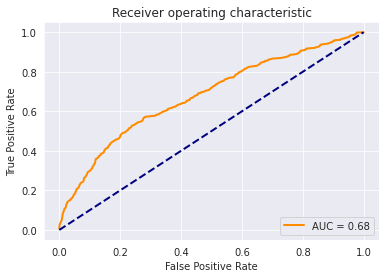

In [46]:
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix 
%matplotlib inline

#cm=metrics.confusion_matrix(y_true, y_pred)
auc = metrics.auc(fpr, tpr)
#print('AUC: %.3f' % auc)
#print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))

# Plot ROC curve
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax1 = sns.lineplot(fpr, tpr, color='darkorange',
        lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1.set_title('Receiver operating characteristic')
ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix 
#fig, ax2 = plot_confusion_matrix(conf_mat=cm,show_normed=False)
plt.show()